In [1]:
# Importing packages and sales dataset
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sales = pd.read_csv('Sales.csv', sep=';', decimal=',')
sales.head()

,Dia,MesStr,Ano,Ordenes,Comensales,Valor medio (Suma),Valor medio (Total),Valor medio,Suma,Descuento,Subtotal,Impuesto,Total
0,27,Mayo,2021,8.0,8.0,5.68,5.68,00:02:46,45.45,NaN,41.33,4.12,45.45
1,26,Mayo,2021,36.0,36.0,9.96,9.96,00:06:37,358.70,NaN,326.10,32.60,358.70
2,25,Mayo,2021,17.0,17.0,10.00,9.67,00:04:24,169.95,5.53,149.47,14.94,164.41
3,24,Mayo,2021,53.0,53.0,9.81,9.60,00:02:24,519.80,11.13,462.46,46.21,508.67
4,23,Mayo,2021,27.0,27.0,11.72,11.65,00:06:19,316.50,1.88,286.04,28.58,314.62


In [2]:
# Renaming the columns
sales.columns = ['day', 'month', 'year', 'orders', 'paxs', 'meanValue',
                 'meanValue2', 'meanValue3', 'sum', 'discount', 'net', 'tax', 'total']

# Keeping only the relevant columns
sales = sales[['day', 'month', 'year', 'orders', 'paxs', 'sum']]
sales = sales.fillna(0)

# Some data cleaning
sales['month'] = sales['month'].map({'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 
                                    'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8, 
                                    'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12})
sales['orders'] = sales['orders'].astype('int')
sales['paxs'] = sales['paxs'].astype('int')

<AxesSubplot:xlabel='date', ylabel='sum'>

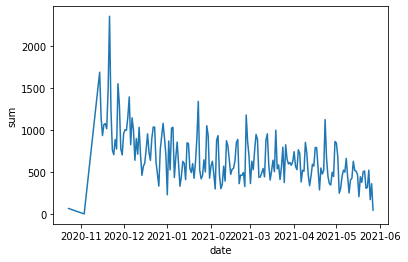

In [3]:
# Creating a datetime column to check sales over time
sales['date'] = pd.to_datetime(sales[['day', 'month', 'year']])
sns.lineplot(data=sales, x='date', y='sum')

<AxesSubplot:xlabel='date', ylabel='sum'>

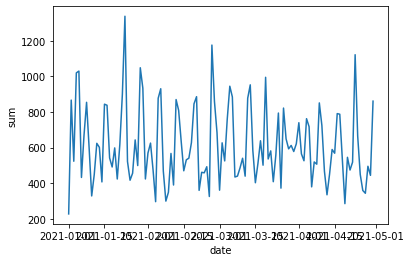

In [4]:
# Keeping only 01/2021 to 04/2021 information since the opening is volatile
sales = sales.loc[sales['year'] == 2021]
sales = sales.loc[sales['month'] < 5]
sns.lineplot(data=sales, x='date', y='sum')

In [5]:
# Getting the weekday of each row
sales['weekday'] = sales['date'].dt.dayofweek

# Getting the week of the month for each row
sales['week'] = sales['day'] / 7
sales['week'] = sales['week'].astype('int')


sales.head()

,day,month,year,orders,paxs,sum,date,weekday,week
27,30,4,2021,62,62,861.15,2021-04-30,4,4
28,29,4,2021,45,45,444.40,2021-04-29,3,4
29,28,4,2021,44,44,495.40,2021-04-28,2,4
30,27,4,2021,35,35,343.85,2021-04-27,1,3
31,26,4,2021,37,37,359.50,2021-04-26,0,3


In [6]:
# Defining a function to plot distribution of the target across the features

def visualization(x, y, graph=sns.boxplot):
  """ 
  Create a 3 column grid to plot each column of a DataFrame
  across a the values from single column of the DataFrame
  """

  features = list(x.columns)
  cols = 3
  rows = int(len(features)/3) + (len(features) % 3 > 0)
  
  fig, axs = plt.subplots(figsize=(20, 5*rows))

  for i in range(len(features)):
    plt.subplot(rows, cols, i+1)
    graph(x=x[features[i]], y=y)
  
  plt.show()

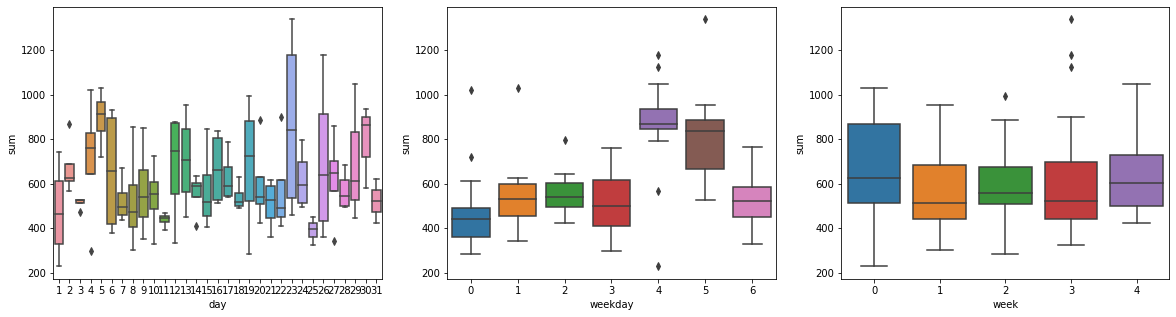

In [7]:
# Defining the features
features = ['day', 'weekday', 'week']


visualization(x=sales[features], y=sales['sum'])

In [8]:
# Defining a function to plot the target distribution accross all pairs of features

def pair_visualization(df, target):
    """
    Visualize the target distribution accross all the pairs
    of features
    """    
    
    features = list(df.columns)
    features.remove(target)
    
    cols = 3
    # rows = int(len(features)/3) + (len(features) % 3 > 0)
    
    rows = np.math.factorial(len(features)) / (np.math.factorial(2) * np.math.factorial(len(features) - 2))
    rows = int(np.ceil(rows/3))
    
    place = 0
    
    fig, axs = plt.subplots(figsize=(20, 5*rows))
    
    print(f'rows: {rows}\nfeatures: {features}')
    
    for i in range(len(features)):
        for j in range(len(features)):
            if j > i:
                place = place + 1
                plt.subplot(rows, cols, place)
                sns.scatterplot(data=df, x=features[i], y=features[j], hue=target, legend=False, palette='Blues')
    plt.show()

rows: 1
features: ['day', 'weekday', 'week']


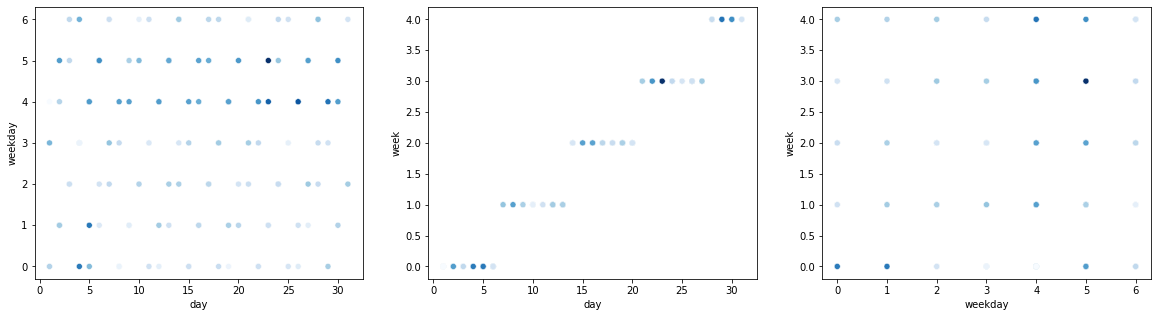

In [9]:
df = sales[['day', 'weekday', 'week', 'sum']]

pair_visualization(df, 'sum')

day vs. weekday


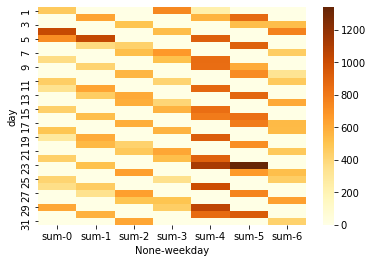



day vs. week


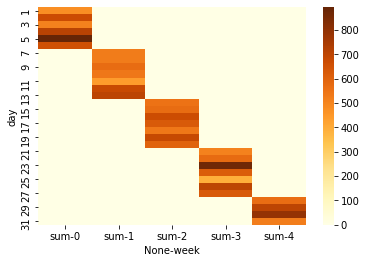



weekday vs. week


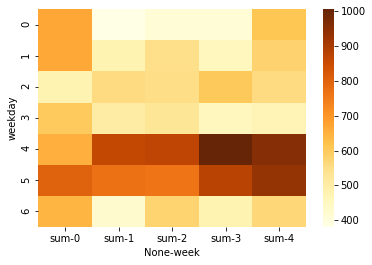

In [10]:
features = list(df.columns)
features.remove('sum')

for i in range(len(features)):
    for j in range(len(features)):
        if j > i:
            pivot = df.groupby(by=[features[i], features[j]]).mean()
            pivot = pivot[['sum']].unstack().fillna(0)
            sns.heatmap(pivot, cmap='YlOrBr')
            print(f'{features[i]} vs. {features[j]}')
            plt.show()
            print('\n')



In [11]:
# Creating a feature combining Fridays and Saturdays with the week number
df['hot_dates'] = (df['weekday'] == 4) | (df['weekday'] == 5)
df['hot_dates'] = df['hot_dates'] * (df['week'] + df['weekday']) + (df['week'] == 0)

In [12]:
# Creating a feature that contains the average sells for each weekday
mean_sales = df.groupby(by='weekday').mean()
mean_sales = mean_sales['sum'].to_dict()
df['weekday_sales'] = df['weekday'].map(mean_sales)

# Creating a feature that contains the average sells for each week
mean_sales = df.groupby(by='week').mean()
mean_sales = mean_sales['sum'].to_dict()
df['week_sales'] = df['week'].map(mean_sales)

<AxesSubplot:>

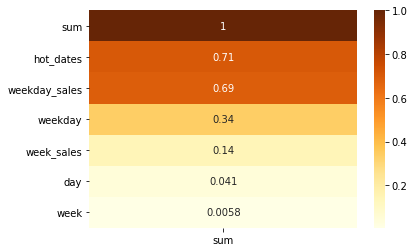

In [13]:
# Checking the correlations between the features and the target
corr = df.corr().abs()
sns.heatmap(corr[['sum']].sort_values(by='sum', ascending=False), cmap='YlOrBr', annot=True)

In [14]:
# Keeping the five features with highest correlation
feats = corr[['sum']].sort_values(by='sum', ascending=False).index.tolist()
feats.remove('sum')
feats = feats[0:5]

In [15]:
# Import ML regression models and scoring function

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ARDRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error

sgd = Pipeline([('scaler', StandardScaler()), ('sgd', SGDRegressor())])
reg = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])
ridge = Pipeline([('scaler', StandardScaler()), ('ridge', RidgeCV())])
ard = Pipeline([('scaler', StandardScaler()), ('ard', ARDRegression())])

# models = [sgd, reg, ridge, ard]
models = [sgd, reg, ridge, ard]
y = df['sum']
errors = pd.DataFrame()
mse = pd.DataFrame()
IQR = pd.DataFrame()

# Train model for each model and for each n most correlated features
for i in range(len(feats)):
    X = df[feats[0:i+1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=20)
    
    
    for model in models:
        model.fit(X_train, y_train)
        model_name = model.get_params()["steps"][1][0]
        y_pred = model.predict(X_test)
        errors[f'{model_name} {len(X.columns)}'] = y_test - y_pred
        IQR[f'{model_name} {len(X.columns)}'] = [np.percentile(errors, 25), np.percentile(errors, 75)]
        mserror = round(mean_squared_error(y_test, y_pred),2)
        mse[f'{model_name} {len(X.columns)}'] = [mserror]
        print(model_name)
        print(f'Features: {list(X.columns)}')
        print(f'Mean error: {round(np.median(errors),2)}€')
        print(f'Mean absolute error: {round(mean_absolute_error(y_test, y_pred),2)}€')
        print(f'Mean squared error: {mserror}€')
        print(f'Max error: {round(max_error(y_test, y_pred),2)}€')
        print('\n')

sgd
Features: ['hot_dates']
Mean error: -11.34€
Mean absolute error: 125.97€
Mean squared error: 27678.47€
Max error: 501.66€


reg
Features: ['hot_dates']
Mean error: -11.41€
Mean absolute error: 125.94€
Mean squared error: 27672.07€
Max error: 501.9€


ridge
Features: ['hot_dates']
Mean error: -11.86€
Mean absolute error: 127.47€
Mean squared error: 28033.98€
Max error: 501.93€


ard
Features: ['hot_dates']
Mean error: -12.46€
Mean absolute error: 127.92€
Mean squared error: 28139.02€
Max error: 503.52€


sgd
Features: ['hot_dates', 'weekday_sales']
Mean error: -13.63€
Mean absolute error: 121.94€
Mean squared error: 27300.79€
Max error: 543.43€


reg
Features: ['hot_dates', 'weekday_sales']
Mean error: -13.63€
Mean absolute error: 123.21€
Mean squared error: 27346.19€
Max error: 526.96€


ridge
Features: ['hot_dates', 'weekday_sales']
Mean error: -16.43€
Mean absolute error: 129.51€
Mean squared error: 29075.4€
Max error: 541.28€


ard
Features: ['hot_dates', 'weekday_sales']
Mean e

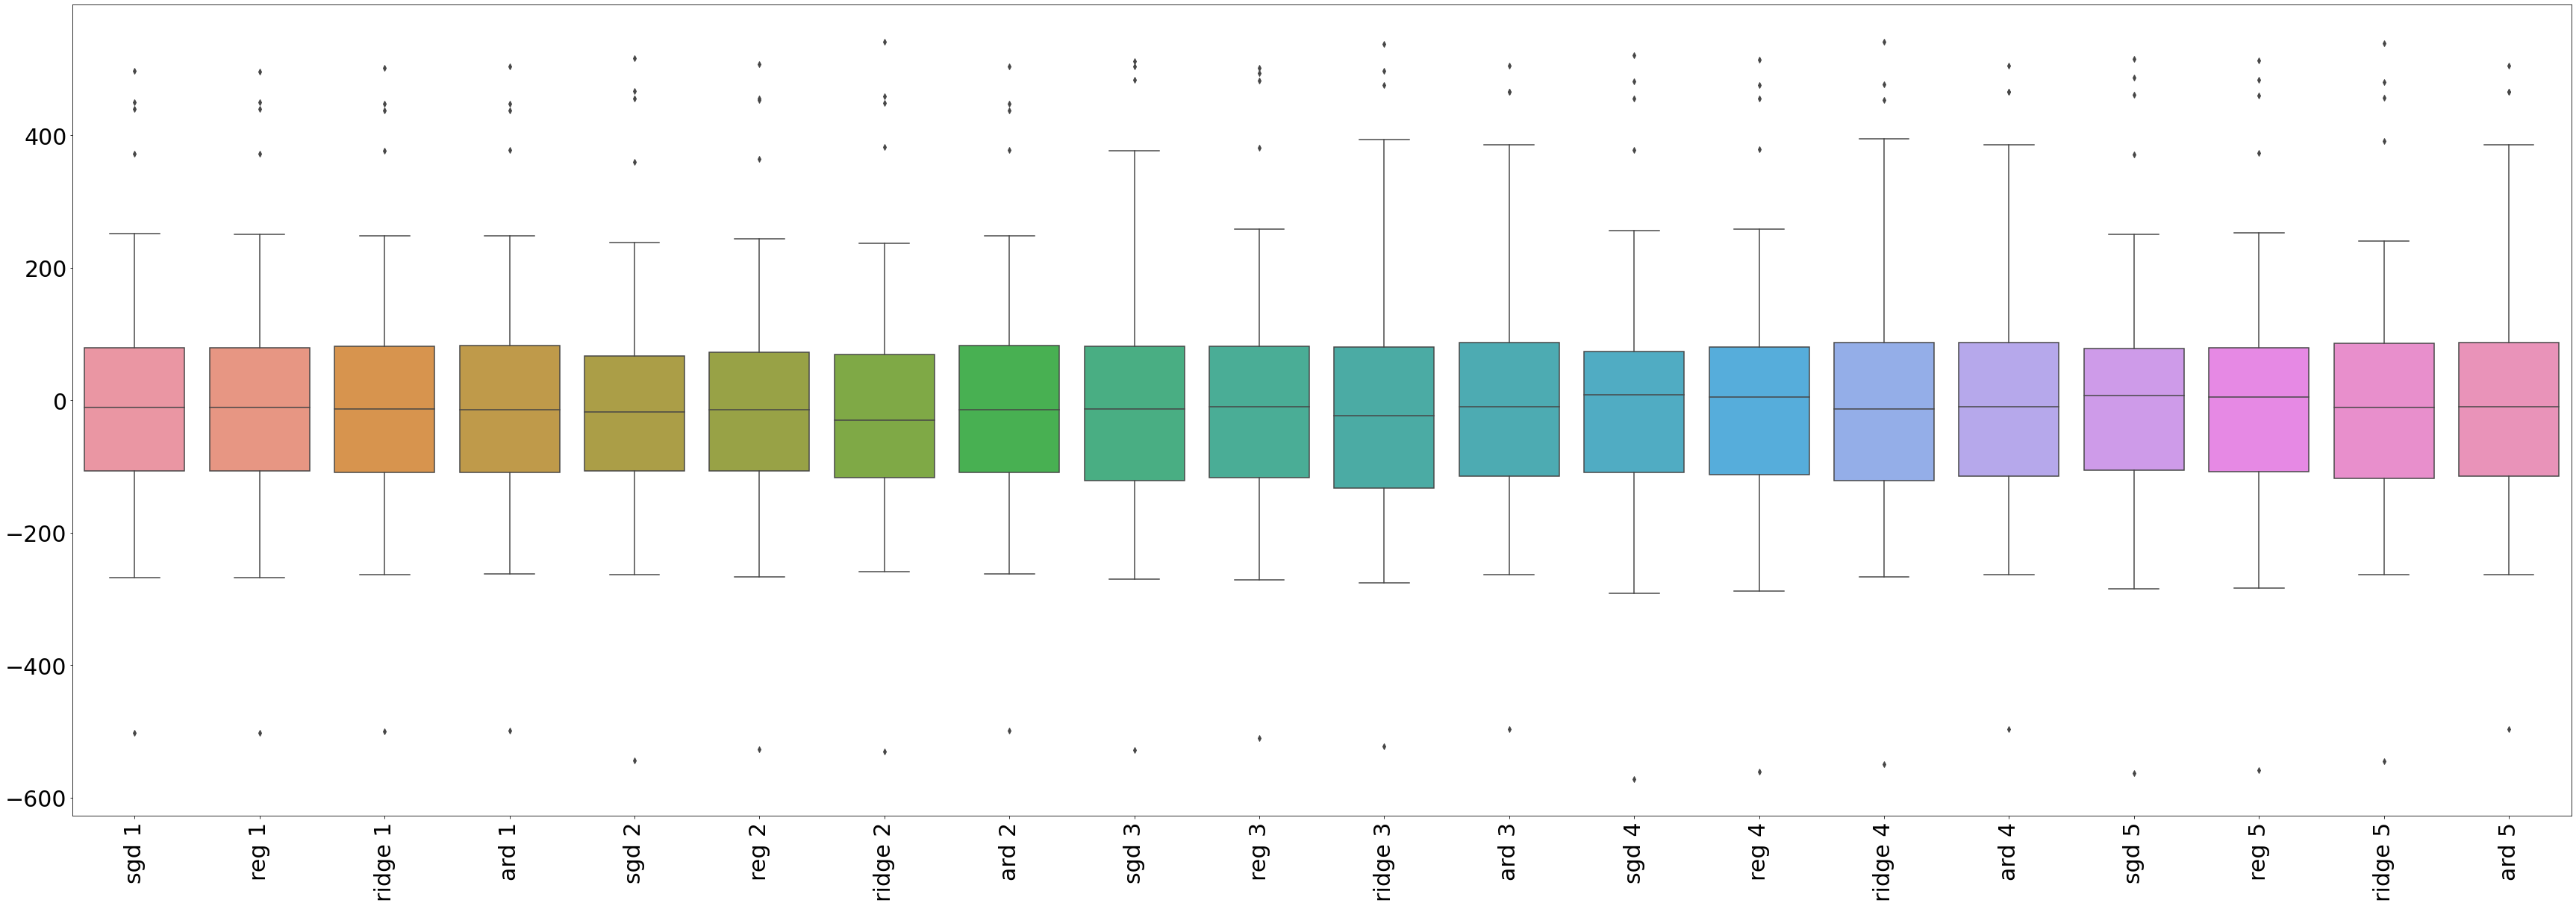

In [16]:
# Plotting error distribution for each model
ax, fig = plt.subplots(figsize=(60, 20))
sns.boxplot(data=errors)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.show()

In [17]:
# Displaying the five lowest mean squared error
mse = mse.transpose()
mse = mse.sort_values(by=0)
mse.head()

,0
sgd 2,27300.79
reg 2,27346.19
reg 1,27672.07
sgd 1,27678.47
sgd 4,27872.54


In [18]:
# Displaying the interquartile range to see how spreaded are the errors
IQR = IQR.transpose()
IQR['range'] = np.abs(IQR[1] - IQR[0])
IQR = IQR.sort_values(by='range')
IQR.head()

,0,1,range
sgd 1,-106.934761,79.625018,186.559779
reg 1,-107.032934,79.598877,186.631810
reg 2,-108.332859,79.393788,187.726647
sgd 2,-108.332859,80.104682,188.437541
ridge 2,-110.599056,78.108940,188.707997
